# Make cross section showing differences between coarse / fine simulations.

Make plots of density, online numerical mixing $\mathcal{M}_{num, on}$, resolved vertical mixing $\chi_v^s$ calculated online, resolved horizontal mixing $\chi_H^s$ calculated offline, horizontal salinity gradient magnitude $|\nabla_H s|$, and vertical shear magnitude $\sqrt{(\partial_zu)^2+(\partial_zv)^2}$

In [1]:
#Packages - not all are necessary, just standard imports
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 11})
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
%matplotlib inline

#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree()

In [2]:
# Open the parent and child models 
path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
ds_avg = xroms.open_mfnetcdf(path)
ds_avg, grid_avg = xroms.roms_dataset(ds_avg)

path1 = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_child_0000*.nc')
ds_avg_child = xroms.open_mfnetcdf(path1)
ds_avg_child, grid_avg_child = xroms.roms_dataset(ds_avg_child)

#Parent model slices
xislice = slice(271,404)
etaslice = slice(31,149)

#Child model slices
xislice_child = slice(8, 677-8)
etaslice_child = slice(8, 602-8)

In [3]:
def calc_kh(ds):
    '''
Calculates the horizontal eddy diffusivity scaled to 
the grid size
    '''
    dA = ds.dA
    dA_max = (np.sqrt(dA)).max()
    kh_0 = 1.0 #m^2/s
    kh = (kh_0/dA_max)*(np.sqrt(dA))
    return kh

kh_parent = calc_kh(ds_avg)
kh_child = calc_kh(ds_avg_child)

# Indexing for cross-sections 

In [4]:
#Slices for cross section
xislice_cs = 396
etaslice_cs = etaslice
xislice_cs_child = 625 #633-8

latsub = ds_avg.lat_rho.isel(eta_rho = etaslice_cs, xi_rho = xislice_cs)
lonsub = ds_avg.lon_rho.isel(eta_rho = etaslice_cs, xi_rho = xislice_cs)
latsub_child = ds_avg_child.lat_rho.isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child)
lonsub_child = ds_avg_child.lon_rho.isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child)

#Check to make sure indexing is correct. print difference in lat/lon between simulations, if zero good to go. 
print('Latitude difference - parent and child grid',latsub.values-latsub_child[::5].values)
print('Longitude difference - parent and child grid',lonsub.values-lonsub_child[::5].values)

Latitude difference - parent and child grid [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Longitude difference - parent and child grid [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
#Copute density, numerical and physical mixing at the cross sections
model_time = datetime(2010, 6, 8, 0, 30) 

#Density
density = xroms.potential_density(ds_avg.temp.isel(eta_rho = etaslice_cs, xi_rho = xislice_cs).sel(ocean_time = model_time), 
                                  ds_avg.salt.isel(eta_rho = etaslice_cs, xi_rho = xislice_cs).sel(ocean_time = model_time), 
                                  z=0).load()

density_child = xroms.potential_density(ds_avg_child.temp.isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child).sel(ocean_time = model_time), 
                                        ds_avg_child.salt.isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child).sel(ocean_time = model_time), 
                                        z=0).load()
#Online numerical mixing
mnum = ds_avg.dye_03.isel(eta_rho = etaslice_cs, xi_rho = xislice_cs).sel(ocean_time = model_time).load()
mnum_child = ds_avg_child.dye_03.isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child).sel(ocean_time = model_time).load()

#Online resolved vertical mixing. Interpolate to s-rho points
chi = ds_avg.AKr.isel(eta_rho = etaslice_cs, xi_rho = xislice_cs).sel(ocean_time = model_time).load()
chi_rho = grid_avg.interp(chi, 'Z')

chi_child = ds_avg_child.AKr.isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child).sel(ocean_time = model_time).load()
chi_child_rho = grid_avg_child.interp(chi_child, 'Z')

#Assign the coordinates for plotting. We need s-w points for plotting the bottom
z_w = ds_avg.z_w.isel(eta_rho = etaslice_cs, xi_rho = xislice_cs).sel(ocean_time = model_time)[0]
z_w_child = ds_avg_child.z_w.isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child).sel(ocean_time = model_time)[0]

chi_srho = chi_rho.assign_coords({'lat_rho':(ds_avg.lat_rho.isel(eta_rho = etaslice_cs, xi_rho = xislice_cs)), 
                                  'z_rho':(ds_avg.z_rho.sel(ocean_time = model_time).isel(eta_rho = etaslice_cs, xi_rho = xislice_cs))})

chi_srho_child = chi_child_rho.assign_coords({'lat_rho':(ds_avg_child.lat_rho.isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child)), 
                                              'z_rho':(ds_avg_child.z_rho.sel(ocean_time = model_time).isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child))})

#Vertical shear
dudz = xroms.dudz(ds_avg.u, grid_avg)
dvdz = xroms.dvdz(ds_avg.v, grid_avg)
dudz = grid_avg.interp(xroms.to_rho(dudz, grid_avg), 'Z')
dvdz = grid_avg.interp(xroms.to_rho(dvdz, grid_avg), 'Z')

vshear = np.sqrt(dudz ** 2 + dvdz ** 2).isel(eta_rho = etaslice_cs, xi_rho = xislice_cs).sel(ocean_time = model_time).load()
vshear_coord = vshear.assign_coords({'lat_rho':(ds_avg.lat_rho.isel(eta_rho = etaslice_cs, xi_rho = xislice_cs)), 
                                     'z_rho':(ds_avg.z_rho.sel(ocean_time = model_time).isel(eta_rho = etaslice_cs, xi_rho = xislice_cs))})

dudz_child = xroms.dudz(ds_avg_child.u, grid_avg_child)
dvdz_child = xroms.dvdz(ds_avg_child.v, grid_avg_child)
dudz_child = grid_avg_child.interp(xroms.to_rho(dudz_child, grid_avg_child), 'Z')
dvdz_child = grid_avg_child.interp(xroms.to_rho(dvdz_child, grid_avg_child), 'Z')

vshear_child = np.sqrt(dudz_child ** 2 + dvdz_child ** 2).isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child).sel(ocean_time = model_time).load()
vshear_coord_child = vshear_child.assign_coords({'lat_rho':(ds_avg_child.lat_rho.isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child)), 
                                             'z_rho':(ds_avg_child.z_rho.sel(ocean_time = model_time).isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child))})

#Horizontal salinity gradient magnitude using Jacobian. 
dsdxi, dsdeta = xroms.hgrad(ds_avg.salt, grid_avg)
dsdx = grid_avg.interp(xroms.to_rho(dsdxi, grid_avg), 'Z')
dsdy = grid_avg.interp(xroms.to_rho(dsdeta, grid_avg), 'Z')

sgradmag = np.sqrt(dsdx**2+dsdy**2).isel(eta_rho = etaslice_cs, xi_rho = xislice_cs).sel(ocean_time = model_time).load()
sgradmag_coords = sgradmag.assign_coords({'lat_rho':(ds_avg.lat_rho.isel(eta_rho = etaslice_cs, xi_rho = xislice_cs)), 
                                          'z_rho':(ds_avg.z_rho.sel(ocean_time = model_time).isel(eta_rho = etaslice_cs, xi_rho = xislice_cs))})

dsdxi_child, dsdeta_child = xroms.hgrad(ds_avg_child.salt, grid_avg_child)
dsdx_child = grid_avg_child.interp(xroms.to_rho(dsdxi_child, grid_avg_child), 'Z')
dsdy_child = grid_avg_child.interp(xroms.to_rho(dsdeta_child, grid_avg_child), 'Z')

sgradmag_child = np.sqrt(dsdx_child**2+dsdy_child**2).isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child).sel(ocean_time = model_time).load()
sgradmag_child_coords = sgradmag_child.assign_coords({'lat_rho':(ds_avg_child.lat_rho.isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child)), 
                                                      'z_rho':(ds_avg_child.z_rho.sel(ocean_time = model_time).isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child))})

# Resolved horizontal mixing 
def chih_cs(grid, ds, kh, etaslice, xislice):
    '''
Computes the horizontal component of salinity variance dissipation using Jacobian
Notes: chi_h = 2 * kappa_h * \nabla_H(s)^2
    '''
    dsaltdxi, dsaltdeta = xroms.hgrad(ds.salt, grid)
    dsdx_rho = grid.interp(xroms.to_rho(dsaltdxi, grid), 'Z')
    dsdy_rho = grid.interp(xroms.to_rho(dsaltdeta, grid), 'Z')

    chih = 2*kh*(dsdx_rho**2+dsdy_rho**2)

    return chih

chih = chih_cs(grid_avg, ds_avg, kh_parent, etaslice, xislice)
chih_child = chih_cs(grid_avg_child, ds_avg_child, kh_child, etaslice_child, xislice_child)

chih_cs = chih.isel(eta_rho = etaslice_cs, xi_rho = xislice_cs).sel(ocean_time = model_time).load()
chih_coords = chih_cs.assign_coords({'lat_rho':(ds_avg.lat_rho.isel(eta_rho = etaslice_cs, xi_rho = xislice_cs)), 
                                     'z_rho':(ds_avg.z_rho.sel(ocean_time = model_time).isel(eta_rho = etaslice_cs, xi_rho = xislice_cs))})
chih_cs_child = chih_child.isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child).sel(ocean_time = model_time).load()
chih_cs_child_coords = chih_cs_child.assign_coords({'lat_rho':(ds_avg_child.lat_rho.isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child)), 
                                                'z_rho':(ds_avg_child.z_rho.sel(ocean_time = model_time).isel(xi_rho = xislice_child, eta_rho = etaslice_child).isel(xi_rho = xislice_cs_child))})


# Make plot 

Text(29.35, -88, '(l)')

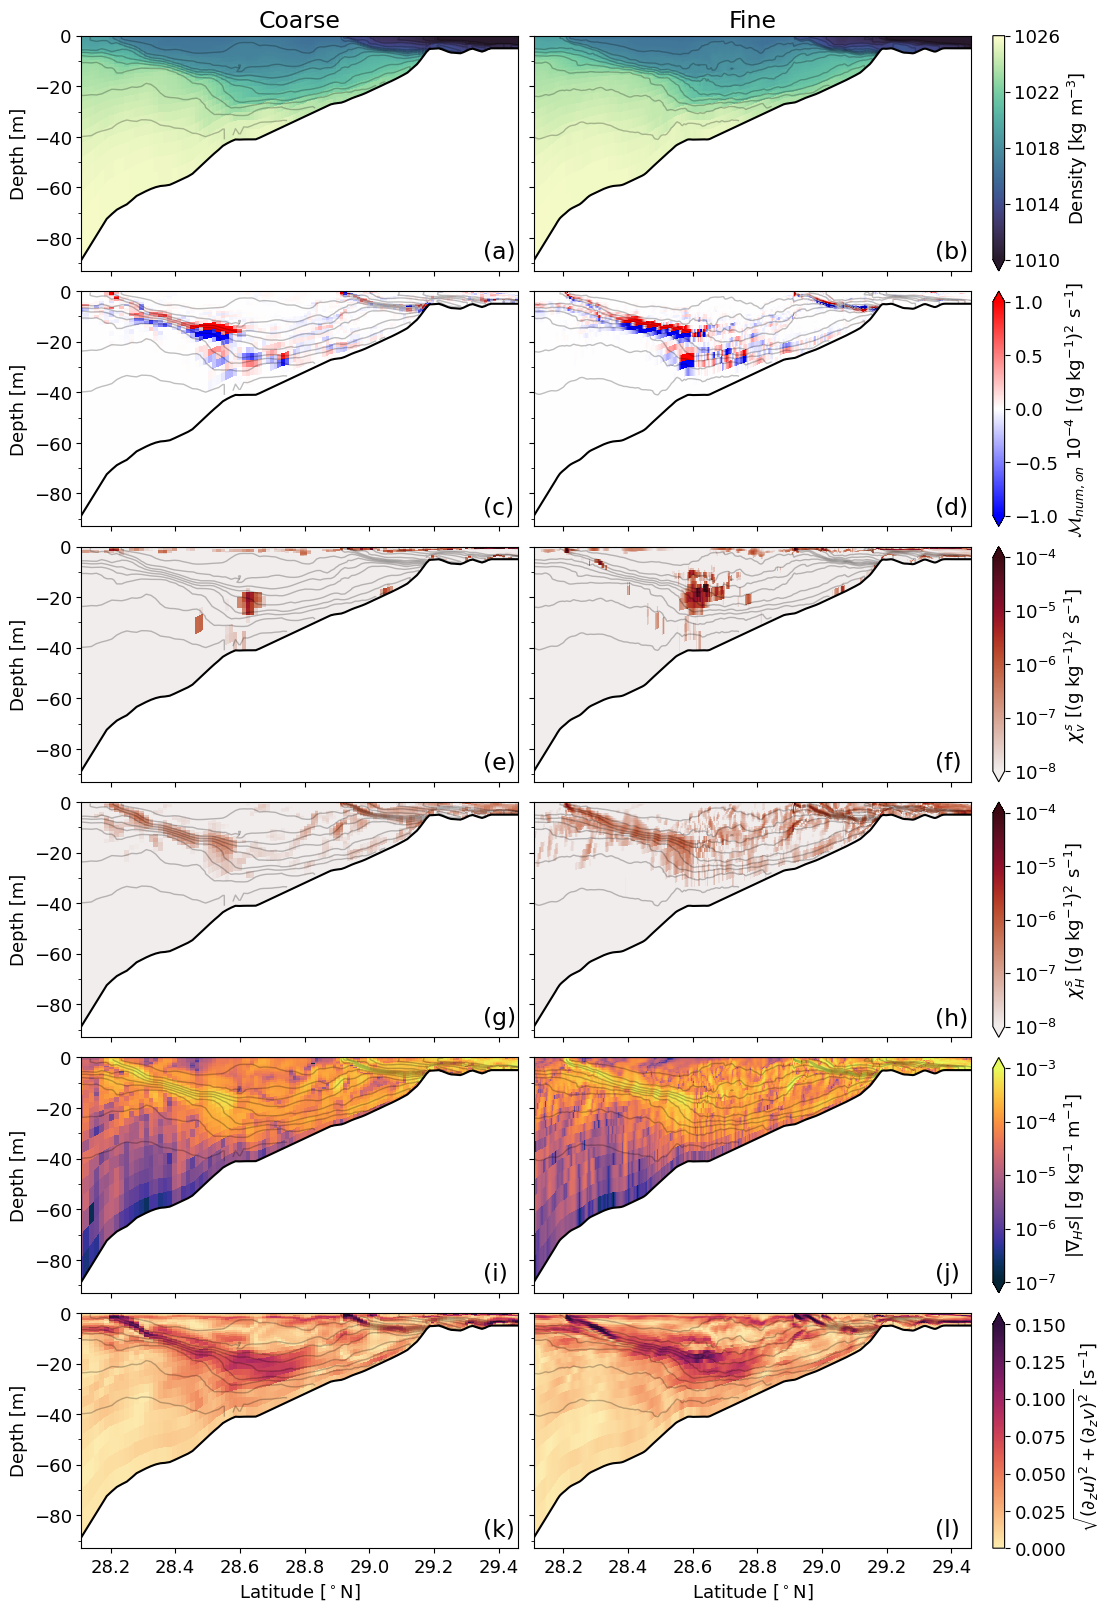

In [6]:
plt.rcParams.update({'font.size': 13})
import matplotlib.ticker as tick

def fmt(x, pos):
    '''
Produce scientific notation in subplots. 
    '''
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

fig, ax = plt.subplots(6,2, figsize = (11,((8/3)*6)), constrained_layout = True)

#Plot bottom line
for i in range(6):
    z_w.plot(x = 'lat_rho', ax = ax[i,0], lw = 1.5, color = 'k')
    z_w_child.plot(x = 'lat_rho', ax = ax[i,1], lw = 1.5, color = 'k')
#Plot isopycnals
for i in range(6):
    density.plot.contour(ax = ax[i,0], x = 'lat_rho', y = 'z_rho', add_colorbar = False, levels = np.arange(1010,1027), colors = 'black', alpha = 0.25, linewidths  =1)
    density_child.plot.contour(ax = ax[i,1], x = 'lat_rho', y = 'z_rho', add_colorbar = False, levels = np.arange(1010,1027), colors = 'black', alpha = 0.25, linewidths  =1)
#Density
m1 = density.plot(ax = ax[0,0], x = 'lat_rho', y = 'z_rho', add_colorbar = False, vmin = 1010, vmax = 1026, cmap = cmo.deep_r)#plt.get_cmap('cividis'))
m2 = density_child.plot(ax = ax[0,1], x = 'lat_rho', y = 'z_rho', add_colorbar = False, vmin = 1010, vmax = 1026, cmap = cmo.deep_r)#cmap = plt.get_cmap('cividis'))
#Numerical mixing
m3 = (mnum*10**4).plot(ax = ax[1,0], x = 'lat_rho', y = 'z_rho', add_colorbar = False, vmin = -.0001*10**4, vmax = .0001*10**4, cmap = plt.get_cmap('bwr'))
m4 = (mnum_child*10**4).plot(ax = ax[1,1], x = 'lat_rho', y = 'z_rho', add_colorbar = False, vmin = -.0001*10**4, vmax = .0001*10**4, cmap = plt.get_cmap('bwr'))
#Resolved vertical mixing
m5 = np.log10(chi_srho).plot(ax = ax[2,0], x = 'lat_rho', y = 'z_rho', add_colorbar = False, vmin = -8, vmax = -4, cmap = cmo.amp)
m6 = np.log10(chi_srho_child).plot(ax = ax[2,1], x = 'lat_rho', y = 'z_rho', add_colorbar = False, vmin = -8, vmax = -4, cmap = cmo.amp)
#Resolved horizontal mixing
m7 = np.log10(chih_coords).plot(ax = ax[3,0], x = 'lat_rho', y = 'z_rho', add_colorbar = False, vmin = -8, vmax = -4, cmap = cmo.amp)
m8 = np.log10(chih_cs_child_coords).plot(ax = ax[3,1], x = 'lat_rho', y = 'z_rho', add_colorbar = False, vmin = -8, vmax = -4, cmap = cmo.amp)
#Horizontal salinity gradient magitude. 
m9 = np.log10(sgradmag_coords).plot(ax = ax[4,0], x = 'lat_rho', y = 'z_rho', add_colorbar = False, vmin = -7, vmax = -3, cmap = cmo.thermal)
m10 = np.log10(sgradmag_child_coords).plot(ax = ax[4,1], x = 'lat_rho', y = 'z_rho', add_colorbar = False, vmin = -7, vmax = -3, cmap = cmo.thermal)

m11 = (vshear_coord).plot(ax = ax[5,0], x = 'lat_rho', y = 'z_rho', add_colorbar = False, vmin = 0, vmax = 0.15, cmap = cmo.matter)
m12 = (vshear_coord_child).plot(ax = ax[5,1], x = 'lat_rho', y = 'z_rho', add_colorbar = False, vmin = 0, vmax = 0.15, cmap = cmo.matter)

ticks = [1010, 1014, 1018, 1022, 1026]
cb1 = fig.colorbar(m2, ax = ax[0,1], extend = 'min', ticks = ticks, label = r'Density [kg m$^{-3}$]')
cb2 = fig.colorbar(m4, ax = ax[1,1], extend = 'both', label = r'$\mathcal{M}_{num, on}$ $10^{-4}$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
cb3 = fig.colorbar(m6, ax = ax[2,1], extend = 'both', label = r'$\chi_v^s$ [(g kg$^{-1}$)$^2$ s$^{-1}$]', format=tick.FormatStrFormatter('$10^{%d}$'))
cb3 = fig.colorbar(m8, ax = ax[3,1], extend = 'both', label = r'$\chi_H^s$ [(g kg$^{-1}$)$^2$ s$^{-1}$]', format=tick.FormatStrFormatter('$10^{%d}$'))
cb4 = fig.colorbar(m10, ax = ax[4,1], extend = 'both', label = r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]', format=tick.FormatStrFormatter('$10^{%d}$'))
cb5 = fig.colorbar(m12, ax = ax[5,1], extend = 'max', label = r'$\sqrt{(\partial_z u)^2 + (\partial_z v)^2}$ [s$^{-1}$]')

for i in range(6):
    for j in range(2):
        ax[i,j].set_ylabel('')
        ax[i,j].set_title('')
        ax[i,j].set_ylim(-93, 0)
        ax[i,j].set_xlim(28.11, 29.46)
        ax[i,0].set_ylabel('Depth [m]')
        ax[i,j].yaxis.set_minor_locator(MultipleLocator(10))
        
for i in range(5):
    for j in range(2):
        ax[i,j].set_xlabel('')
        ax[i,j].set_xticklabels([])
        ax[i,1].set_yticklabels([])
        
ax[0,0].set_title('Coarse', fontsize = 17)
ax[0,1].set_title('Fine', fontsize = 17)
ax[5,0].set_xlabel(r'Latitude [$^\circ$N]')
ax[5,1].set_xlabel(r'Latitude [$^\circ$N]')
ax[5,1].set_yticklabels([])

ax[0,0].annotate('(a)', xy = (29.35, -88), color = 'k', fontsize = 17)
ax[0,1].annotate('(b)', xy = (29.35, -88), color = 'k', fontsize = 17)
ax[1,0].annotate('(c)', xy = (29.35, -88), color = 'k', fontsize = 17)
ax[1,1].annotate('(d)', xy = (29.35, -88), color = 'k', fontsize = 17)
ax[2,0].annotate('(e)', xy = (29.35, -88), color = 'k', fontsize = 17)
ax[2,1].annotate('(f)', xy = (29.35, -88), color = 'k', fontsize = 17)
ax[3,0].annotate('(g)', xy = (29.35, -88), color = 'k', fontsize = 17)
ax[3,1].annotate('(h)', xy = (29.35, -88), color = 'k', fontsize = 17)
ax[4,0].annotate('(i)', xy = (29.35, -88), color = 'k', fontsize = 17)
ax[4,1].annotate('(j)', xy = (29.35, -88), color = 'k', fontsize = 17)
ax[5,0].annotate('(k)', xy = (29.35, -88), color = 'k', fontsize = 17)
ax[5,1].annotate('(l)', xy = (29.35, -88), color = 'k', fontsize = 17)
# plt.savefig('cross_section_revised.jpg', dpi = 300, bbox_inches="tight")  